Neural Networks


In [1]:
import pandas as pd
import joblib
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Create a dictionary to store data for each horizon
test_data = {}
horizons = [1, 5, 21]

# Load and filter test data for the specified date
for horizon in horizons:
    file_path = f'C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Data/merged_results_h{horizon}.csv'
    
    df = pd.read_csv(file_path)

    # Filter only for 2018-09-17
    df = df[df['date'] == '2020-05-01'].copy()
    
    # Keep only relevant columns
    df = df.copy()
    
    # Store filtered and reduced data
    test_data[horizon] = df

    # Display info
    print(f"Filtered test_data_h{horizon} for '2020-05-01': {df.shape}")
    print(df.head())
    print("-" * 50)


Filtered test_data_h1 for '2020-05-01': (1281, 176)
                                   ID     iv_cw        date  cp_flag  \
990379  2020-05-01_AAPL 200529C292500  0.450584  2020-05-01        1   
990380  2020-05-01_AAPL 200529C295000  0.447356  2020-05-01        1   
990381  2020-05-01_AAPL 200529C297500  0.444564  2020-05-01        1   
990382  2020-05-01_AAPL 200529C300000  0.442207  2020-05-01        1   
990383  2020-05-01_AAPL 200529C305000  0.438777  2020-05-01        1   

        option_price  stock_price  moneyness  time_to_expiry  strike_price  \
990379         8.425      292.425   0.999744              27         292.5   
990380         7.225      292.425   0.991271              27         295.0   
990381         6.200      292.425   0.982941              27         297.5   
990382         5.275      292.425   0.974750              27         300.0   
990383         3.625      292.425   0.958770              27         305.0   

        volume  ...   iv_ahbs     iv_bs  predi

In [2]:
###########################################
# PART 1: NEURAL NETWORK MODEL DEFINITION
###########################################

def create_nn_model(architecture_type, input_dim):

    model = Sequential()
    
    # Define architecture based on specifications
    if architecture_type == 'NN3':
        # Three hidden layers with 32, 16, and 8 neurons
        model.add(Dense(128, activation='sigmoid', input_dim=input_dim))
        model.add(Dense(64, activation='sigmoid'))
        model.add(Dense(16, activation='sigmoid'))
        model.add(Dense(1))
    
    elif architecture_type == 'NN4':
        # Four hidden layers with 32, 16, 8, and 4 neurons
        model.add(Dense(128, activation='sigmoid', input_dim=input_dim))
        model.add(Dense(64, activation='sigmoid'))
        model.add(Dense(32, activation='sigmoid'))
        model.add(Dense(16, activation='sigmoid'))
        model.add(Dense(1))
    
    else:
        raise ValueError("Invalid architecture type. Choose from 'NN3' or 'NN4'.")
    
    # Compile model with Adam optimizer for faster training
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
    
    return model

def train_and_evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test, epochs=100):

    # Early stopping with optimized parameters
    callbacks = [
        EarlyStopping(
            monitor='loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='loss',
            factor=0.5,
            patience=5,
            min_lr=1e-5,
            verbose=1
        )
    ]
    
    # Train model with larger batch size for better speed
    history = model.fit(
        X_train_scaled, y_train,
        epochs=epochs,
        batch_size=128,
        validation_split=0.0,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate model
    y_pred = model.predict(X_test_scaled, batch_size=128, verbose=0)
    mse = mean_squared_error(y_test, y_pred)
    
    return history, mse


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing    import StandardScaler

def prepare_data(option_only, save_paths=True):
    # 1) define features & targets
    exclude = [
      'iv_bs_error','iv_ahbs','iv_ahbs_error','iv_bs','iv_cw','iv_cw_error',
      'impl_volatility'
    ]
    features = [c for c in option_only if c not in exclude]
    X = option_only[features]
    y  = {
      'bs':   option_only['iv_bs_error'],
      'ahbs': option_only['iv_ahbs_error'],
      'cw':   option_only['iv_cw_error']
    }

    # 2) one consistent train/test split
    train_idx, test_idx = train_test_split(
      option_only.index, test_size=0.2, random_state=42
    )
    X_train = X.loc[train_idx]; X_test = X.loc[test_idx]
    y_train = {k: v.loc[train_idx] for k,v in y.items()}
    y_test  = {k: v.loc[test_idx]  for k,v in y.items()}

    # 3) scale
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(
        scaler.transform(X_train),
        columns=features, index=train_idx
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=features, index=test_idx
    )

    # 4) persist
    if save_paths:
        joblib.dump(scaler, 'scaler.pkl')
        joblib.dump(features, 'feature_columns.pkl')

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, features


In [4]:
def predict_and_add_to_test_data(models, test_data, feature_columns, scaler, error_type):

    # Create a copy of the test data to avoid modifying the original
    result_df = test_data
   
    # Extract features from test data as DataFrame (not as numpy array)
    X_test = test_data[feature_columns]
   
    # Scale the features using the pre-fitted scaler and convert back to DataFrame
    # This preserves feature names and prevents the warning
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=feature_columns,
        index=X_test.index
    )
   
    # Original value column name
    original_column = f'iv_{error_type}'
   
    # Generate predictions for each model
    for model_name, model in models.items():
        # Make predictions
        predictions = model.predict(X_test_scaled, batch_size=128, verbose=0)
       
        # Flatten predictions if needed
        if len(predictions.shape) > 1:
            predictions = predictions.flatten()
       
        # Add predictions to the dataframe
        column_name = f'iv_{error_type}_pred_{model_name}'
        result_df[column_name] = predictions
       
        # Calculate corrected value by adding the error prediction to the original value
        result_df[f'iv_{error_type}_corrected_{model_name}'] = result_df[original_column] + predictions
   
    return result_df

In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

def load_models(model_paths_dict):

    loaded_models = {}
    
    for error_type in model_paths_dict:
        loaded_models[error_type] = {}
        
        for model_name, path in model_paths_dict[error_type].items():
            try:
                # Handle Windows paths by using raw strings
                path = path.replace('\\', '/')  # Convert backslashes to forward slashes
                
                # Check if file exists
                if not os.path.exists(path):
                    print(f"✗ {error_type} {model_name}: File not found at {path}")
                    loaded_models[error_type][model_name] = None
                    continue
                
                # Load the model
                print(f"Loading {error_type} {model_name}...")
                model = load_model(path)
                
                # Simple check: can we access layers?
                num_layers = len(model.layers)
                print(f"✓ Model loaded successfully with {num_layers} layers")
                
                # Store loaded model
                loaded_models[error_type][model_name] = model
                
            except Exception as e:
                print(f"✗ Failed to load {error_type} {model_name}: {str(e)}")
                loaded_models[error_type][model_name] = None
    
    return loaded_models

# Example usage
if __name__ == "__main__":
    # Model paths dictionary with proper path handling for Windows
    # Use forward slashes or raw strings to avoid Unicode escape errors
    model_paths_dict = {
        'bs': {
            'NN3': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network forecast/Firm_characteristics/h1/NN3_bs_model_forecast.h5",
            'NN4': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network forecast/Firm_characteristics/h1/NN4_bs_model_forecast.h5"
        },
        'ahbs': {
            'NN3': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network forecast/Firm_characteristics/h1/NN3_ahbs_model_forecast.h5",
            'NN4': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network forecast/Firm_characteristics/h1/NN4_ahbs_model_forecast.h5"
        },
        'cw': {
            'NN3': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network forecast/Firm_characteristics/h1/NN3_cw_model_forecast.h5",
            'NN4': r"C:/Users/maxva/OneDrive - Tilburg University/Msc. Data Science/Master Thesis/Code/Models/Neural Network forecast/Firm_characteristics/h1/NN4_cw_model_forecast.h5"
        }
    }
    
    # Load all models
    loaded_models = load_models(model_paths_dict)
    
    # Print summary of loaded models
    print("\n=== Model Loading Summary ===")
    for error_type in loaded_models:
        for model_name in loaded_models[error_type]:
            status = "✓ Loaded" if loaded_models[error_type][model_name] is not None else "✗ Failed"
            print(f"{error_type} {model_name}: {status}")

Loading bs NN3...


✓ Model loaded successfully with 4 layers
Loading bs NN4...
✓ Model loaded successfully with 5 layers
Loading ahbs NN3...
✓ Model loaded successfully with 4 layers
Loading ahbs NN4...
✓ Model loaded successfully with 5 layers
Loading cw NN3...


✓ Model loaded successfully with 4 layers
Loading cw NN4...
✓ Model loaded successfully with 5 layers

=== Model Loading Summary ===
bs NN3: ✓ Loaded
bs NN4: ✓ Loaded
ahbs NN3: ✓ Loaded
ahbs NN4: ✓ Loaded
cw NN3: ✓ Loaded
cw NN4: ✓ Loaded


In [6]:
scaler_path = r"C:\Users\maxva\OneDrive - Tilburg University\Msc. Data Science\Master Thesis\Code\Models\Neural Network forecast\Firm_characteristics\h1\scaler.pkl"
scaler = joblib.load(scaler_path)

for horizon in horizons:
    # 1) load and copy base test set
    print(f"\n=== Horizon {horizon} ===")
    base_df = test_data[horizon].copy()

    # 2) determine your features once
    exclude_cols = [
        'iv_bs_error', 'iv_ahbs', 'iv_ahbs_error', 'iv_bs', 'iv_cw', 'iv_cw_error',
        'impl_volatility', 'moneyness_category', 'ID', 'date', 'new_id',
        'open_interest', 'option_price', 'prediction_horizon',
        'test_date', 'train_date', 'volume'
    ]
    feature_columns = [c for c in base_df.columns if c not in exclude_cols]

    # 3) loop over error types _and_ models, but update the SAME DataFrame
    df = base_df.copy()
    for error_type in ['bs', 'ahbs', 'cw']:
        print(f"\n-- predicting corrections for {error_type} --")

        models_for_type = loaded_models[error_type]  # e.g. [nn3_model, nn4_model]

        df = predict_and_add_to_test_data(
            models_for_type, df, feature_columns, scaler, error_type
        )

        # show a quick peek
        cols = ['impl_volatility', f'iv_{error_type}']
        for m in ['NN3', 'NN4']:
            cols += [f'iv_{error_type}_pred_{m}', f'iv_{error_type}_corrected_{m}']
        print(df[cols].head(3))

    # 4) after all error types, assign once
    test_data[horizon] = df
    print(f"\n-- test_data_h{horizon} updated --")



=== Horizon 1 ===

-- predicting corrections for bs --
        impl_volatility     iv_bs  iv_bs_pred_NN3  iv_bs_corrected_NN3  \
990379         0.333655  0.466571       -0.113702             0.352868   
990380         0.328039  0.466571       -0.120989             0.345581   
990381         0.320756  0.466571       -0.125425             0.341145   

        iv_bs_pred_NN4  iv_bs_corrected_NN4  
990379       -0.116887             0.349684  
990380       -0.130130             0.336440  
990381       -0.145210             0.321361  

-- predicting corrections for ahbs --
        impl_volatility   iv_ahbs  iv_ahbs_pred_NN3  iv_ahbs_corrected_NN3  \
990379         0.333655  0.466143         -0.114472               0.351672   
990380         0.328039  0.463298         -0.116443               0.346855   
990381         0.320756  0.460615         -0.116683               0.343932   

        iv_ahbs_pred_NN4  iv_ahbs_corrected_NN4  
990379         -0.107093               0.359051  
990380     

In [7]:
print(test_data[1].columns)

Index(['ID', 'iv_cw', 'date', 'cp_flag', 'option_price', 'stock_price',
       'moneyness', 'time_to_expiry', 'strike_price', 'volume',
       ...
       'iv_bs_pred_NN4', 'iv_bs_corrected_NN4', 'iv_ahbs_pred_NN3',
       'iv_ahbs_corrected_NN3', 'iv_ahbs_pred_NN4', 'iv_ahbs_corrected_NN4',
       'iv_cw_pred_NN3', 'iv_cw_corrected_NN3', 'iv_cw_pred_NN4',
       'iv_cw_corrected_NN4'],
      dtype='object', length=188)


In [8]:
file_path = r"C:\Users\maxva\OneDrive - Tilburg University\Msc. Data Science\Master Thesis\Code\Models\LigthGBM Forecast\Firm Characteristics\test_data_horizon_1_for_graph.csv"

test_data_lgb1 = pd.read_csv(file_path)

In [9]:
merged_df = pd.merge(test_data[1], test_data_lgb1, on='ID', how='left', suffixes=('', '_drop'))

# Drop any duplicated columns from lgb1 that already exist in test_data[1]
merged_df = merged_df.loc[:, ~merged_df.columns.str.endswith('_drop')]

print(merged_df.head())


                              ID     iv_cw        date  cp_flag  option_price  \
0  2020-05-01_AAPL 200529C292500  0.450584  2020-05-01        1         8.425   
1  2020-05-01_AAPL 200529C295000  0.447356  2020-05-01        1         7.225   
2  2020-05-01_AAPL 200529C297500  0.444564  2020-05-01        1         6.200   
3  2020-05-01_AAPL 200529C300000  0.442207  2020-05-01        1         5.275   
4  2020-05-01_AAPL 200529C305000  0.438777  2020-05-01        1         3.625   

   stock_price  moneyness  time_to_expiry  strike_price  volume  ...  \
0      292.425   0.999744              27         292.5     276  ...   
1      292.425   0.991271              27         295.0     526  ...   
2      292.425   0.982941              27         297.5     449  ...   
3      292.425   0.974750              27         300.0    1213  ...   
4      292.425   0.958770              27         305.0     267  ...   

   iv_bs_pred_LGB2  iv_bs_corrected_LGB2  iv_ahbs_pred_LGB1  \
0        -0.11254

In [10]:
filtered_df = merged_df[
    ((merged_df['time_to_expiry'] >= 20) & (merged_df['time_to_expiry'] <= 40)) |
    ((merged_df['time_to_expiry'] >= 150) & (merged_df['time_to_expiry'] <= 240))
]


In [11]:
import matplotlib.pyplot as plt

def plot_extended_model_comparisons(df):
    models = {
        'BS': ('iv_bs', 'iv_bs_corrected_NN3', 'iv_bs_corrected_LGB1'),
        'AHBS': ('iv_ahbs', 'iv_ahbs_corrected_NN3', 'iv_ahbs_corrected_LGB1'),
        'CW': ('iv_cw', 'iv_cw_corrected_NN3', 'iv_cw_corrected_LGB1')
    }

    short_term_mask = (df['time_to_expiry'] >= 20) & (df['time_to_expiry'] <= 40)
    long_term_mask = (df['time_to_expiry'] >= 150) & (df['time_to_expiry'] <= 240)

    fig, axs = plt.subplots(3, len(models), figsize=(5 * len(models), 12), sharex='col', sharey='row')
    row_titles = ['', ' + NN', ' + LGB']

    for row_idx, row_title in enumerate(row_titles):
        for col_idx, (model_name, _) in enumerate(models.items()):
            axs[row_idx, col_idx].set_title(f'{model_name}{row_title}', fontsize=20)

    for idx, (model_name, (base_col, nn3_col, lgb1_col)) in enumerate(models.items()):
        # Base Model Row
        axs[0, idx].scatter(df.loc[short_term_mask, 'moneyness'], df.loc[short_term_mask, 'impl_volatility'],
                            color='darkblue', label='Market IV (20-40)', s=10, alpha=0.6)
        axs[0, idx].scatter(df.loc[long_term_mask, 'moneyness'], df.loc[long_term_mask, 'impl_volatility'],
                            color='lightblue', label='Market IV (150-240)', s=10, alpha=0.6)
        axs[0, idx].scatter(df.loc[short_term_mask, 'moneyness'], df.loc[short_term_mask, base_col],
                            color='red', label=f'{model_name} IV (20-40)', s=10, alpha=0.6)
        axs[0, idx].scatter(df.loc[long_term_mask, 'moneyness'], df.loc[long_term_mask, base_col],
                            color='orange', label=f'{model_name} IV (150-240)', s=10, alpha=0.6)
        axs[0, idx].legend(fontsize=10)  # Keep legend small

        # NN3 Corrected Row
        axs[1, idx].scatter(df.loc[short_term_mask, 'moneyness'], df.loc[short_term_mask, 'impl_volatility'],
                            color='darkblue', label='Market IV (20-40)', s=10, alpha=0.6)
        axs[1, idx].scatter(df.loc[long_term_mask, 'moneyness'], df.loc[long_term_mask, 'impl_volatility'],
                            color='lightblue', label='Market IV (150-240)', s=10, alpha=0.6)
        axs[1, idx].scatter(df['moneyness'], df[nn3_col], color='green', label=f'{model_name} + NN3', s=10, alpha=0.6)
        axs[1, idx].legend(fontsize=10)  # Keep legend small

        # LGB1 Corrected Row
        axs[2, idx].scatter(df.loc[short_term_mask, 'moneyness'], df.loc[short_term_mask, 'impl_volatility'],
                            color='darkblue', label='Market IV (20-40)', s=10, alpha=0.6)
        axs[2, idx].scatter(df.loc[long_term_mask, 'moneyness'], df.loc[long_term_mask, 'impl_volatility'],
                            color='lightblue', label='Market IV (150-240)', s=10, alpha=0.6)
        axs[2, idx].scatter(df['moneyness'], df[lgb1_col], color='green', label=f'{model_name} + LGB1', s=10, alpha=0.6)
        axs[2, idx].legend(fontsize=10)  # Keep legend small

    # Y-axis label
    for ax in axs[:, 0]:
        ax.set_ylabel('Implied Volatility', fontsize=18)

    # X-axis label
    for ax in axs[2, :]:
        ax.set_xlabel('Moneyness', fontsize=18)

    # Consistent tick label size
    for ax_row in axs:
        for ax in ax_row:
            ax.tick_params(axis='both', labelsize=14)

    plt.tight_layout()
    plt.show()


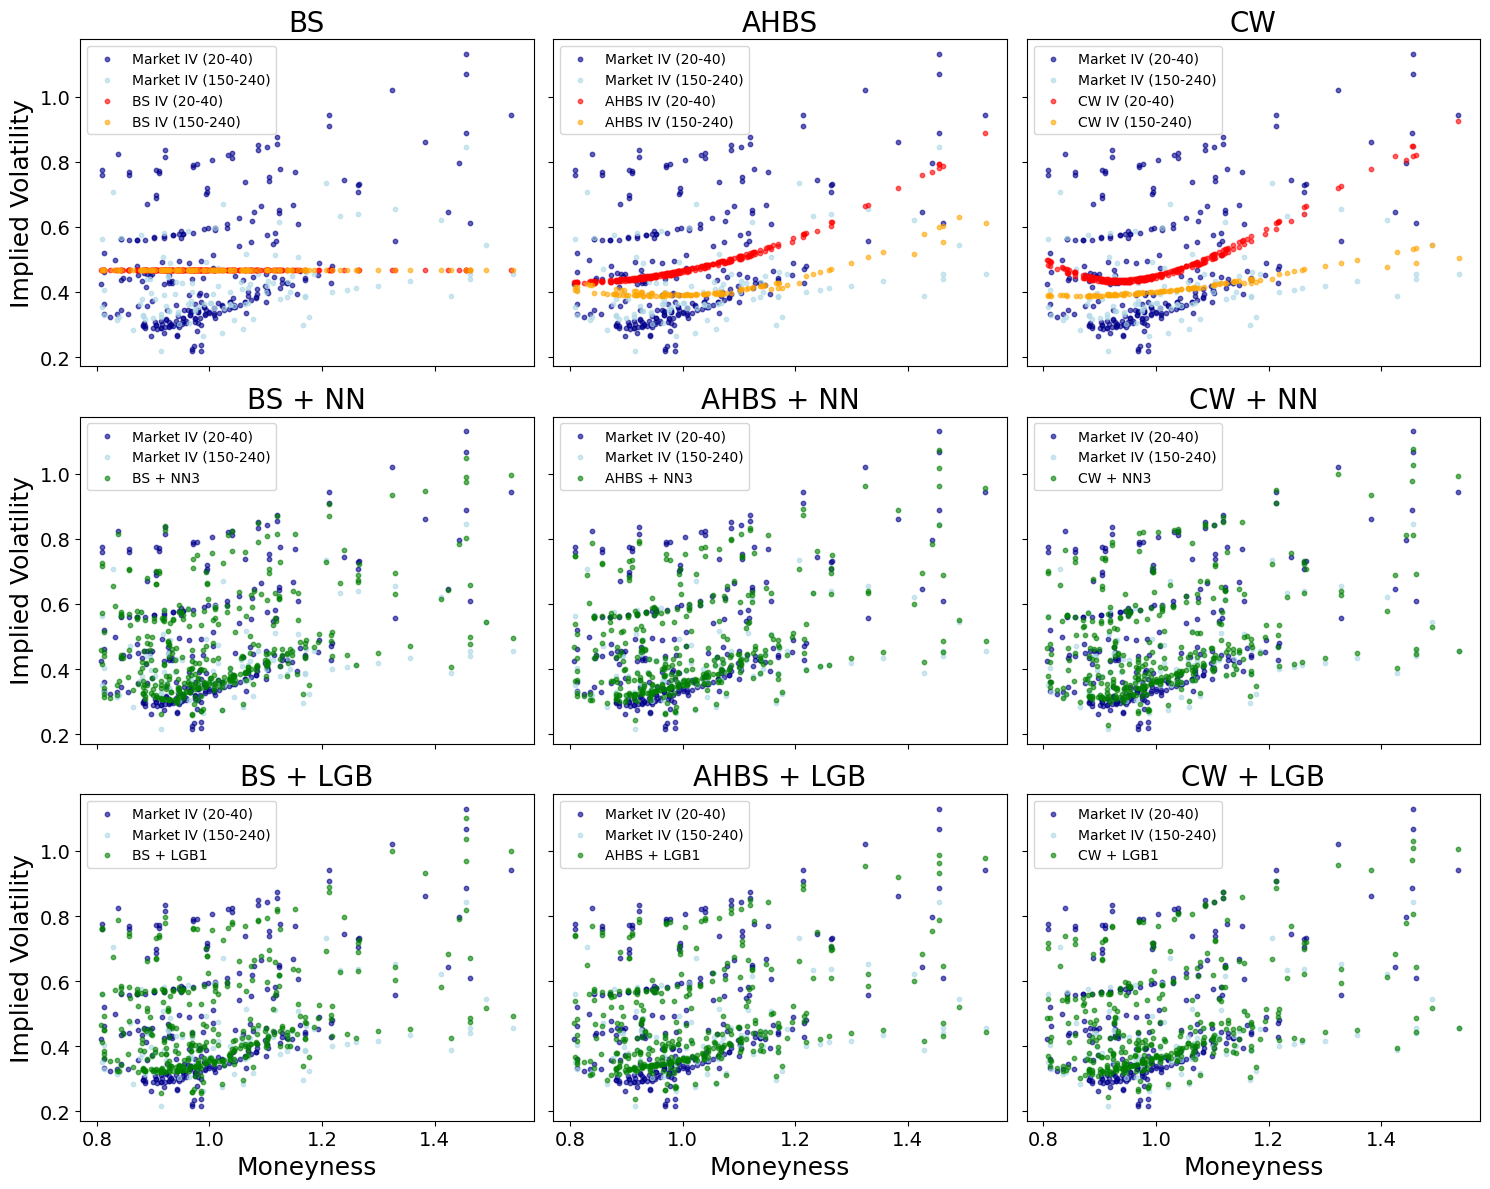

: 

In [ ]:
plot_extended_model_comparisons(filtered_df)
